<a href="https://colab.research.google.com/github/JardiT/DL_1920/blob/master/codes/2_homework/exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand-in 2

## Exercise 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy

import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Choose which device to use
use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

### Download the data

In [3]:
# Apply transformations to the data points before passing them to the network
transform = transforms.Compose([transforms.ToTensor(),  # Transform the data to torch tensors of shape (28, 28, 1), corresponding to 28 * 28 pixels with 1 channel (1 value per pixel that is)
                                transforms.Normalize((0.1307,), (0.3081,)),  # Normalize the images (mean and std for MNIST dataset found online)
                                ])

# Download the MNIST train dataset (used to train the network)
trainset = torchvision.datasets.MNIST(root='./data_mnist',
                                      train=True,
                                      download=True,
                                      transform=transform  # Apply the defined transformation on the data
                                      )

# Download the MNIST test dataset (used to evaluate the trained network)
testset = torchvision.datasets.MNIST(root='./data_mnist',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

batch_size = 128
w, h = 28, 28  # Width, Height
k = 10  # Number of output classes

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,  # Shuffle the dataset for random ordering of train samples
                                          )

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         )



### Defining the MLP architecture

In [4]:
class MLP(nn.Module):
  def __init__(self,
               input_size,  # Size of the input. Here we will first flatten the image to a single vector with the 3 * 32 * 32 values in the image 
               layer_sizes,  # A tuple containing the sizes of the hidden layers of the neural network. So to create a NN with two hidden layers with 32 neurons in each layer you'd set layer_sizes=(32,32)
               output_size):  # The size of the network output. CIFAR10 has 10 output classes
    super(MLP, self).__init__()
    shape = (input_size,) + tuple(layer_sizes) + (output_size,)
    self.layers = nn.ModuleList([nn.Linear(shape[i], shape[i + 1]) for i in range(len(shape) - 1)])  # Store the layers in a ModuleList object so they are recognized by pytorch as submodules of this model

  def forward(self, x):
    for layer in self.layers[:-1]:  # Apply relu activation to all but the last layer in the network
      x = F.relu(layer(x))
    return self.layers[-1](x)

## Exercise 2a
We use a network with 2 layers.

### Defining a train function

In [5]:
def train(net, optimizer, num_epochs):
  test_acc = np.zeros(num_epochs+1)
  # Evaluate the untrained model on the test set
  correct_total = 0
  for i, (x_batch, y_batch) in enumerate(testloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    y_pred = net(x_batch.view(-1, w * h))
    y_pred_max = torch.argmax(y_pred, dim=1)

    correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

  test_acc[0] = correct_total / len(testset.data)
  print(f'epoch: {0}, time: {0:.3f}s, Test accuracy: {test_acc[0]:.3f}')

  start = time.time()
  for epoch in range(1, num_epochs + 1):
    # Iterate through the entire train set
    for i, (x_batch, y_batch) in enumerate(trainloader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

      optimizer.zero_grad()  # Set all currenly stored gradients to zero 

      y_pred = net(x_batch.view(-1, w * h))

      loss = criterion(y_pred, y_batch)

      loss.backward()

      optimizer.step()

      # Compute relevant metrics
          
      y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

      correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

      elapsed = time.time() - start  # Keep track of how much time has elapsed
      
    # Evaluate the model on the test set
    correct_total = 0
    for i, (x_batch, y_batch) in enumerate(testloader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

      y_pred = net(x_batch.view(-1, w * h))
      y_pred_max = torch.argmax(y_pred, dim=1)

      correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

    test_acc[epoch] = correct_total / len(testset.data)
    print(f'epoch: {epoch}, time: {elapsed:.3f}s, Test accuracy: {test_acc[epoch]:.3f}')
  
  return test_acc

### Define the net, criterion and optimizers

In [6]:
netSGD = MLP(w * h, (128, 128), k).to(device)  # Create a new dense neural network with two hidden layers of size 128

print(netSGD)

netAdam = copy.deepcopy(netSGD) # Deepcopym net so that they have the same initialisation; that is a better comparison!

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [7]:
criterion = nn.CrossEntropyLoss()

optimizerSGD = torch.optim.SGD(netSGD.parameters() , lr=0.01)
optimizerAdam = torch.optim.Adam(netAdam.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08)


### Train network with SGD and Adam

In [8]:
num_epochs = 25
epochs = np.arange(0,num_epochs+1)

test_acc_SGD = train(netSGD, optimizerSGD, num_epochs)
test_acc_Adam = train(netAdam, optimizerAdam, num_epochs)

epoch: 0, time: 0.000s, Test accuracy: 0.123
epoch: 1, time: 9.198s, Test accuracy: 0.876
epoch: 2, time: 19.780s, Test accuracy: 0.906
epoch: 3, time: 30.317s, Test accuracy: 0.916
epoch: 4, time: 41.304s, Test accuracy: 0.925
epoch: 5, time: 52.171s, Test accuracy: 0.930
epoch: 6, time: 62.824s, Test accuracy: 0.934
epoch: 7, time: 73.515s, Test accuracy: 0.937
epoch: 8, time: 84.210s, Test accuracy: 0.941
epoch: 9, time: 95.089s, Test accuracy: 0.943
epoch: 10, time: 105.990s, Test accuracy: 0.946
epoch: 11, time: 116.722s, Test accuracy: 0.948
epoch: 12, time: 127.493s, Test accuracy: 0.951
epoch: 13, time: 138.082s, Test accuracy: 0.955
epoch: 14, time: 148.644s, Test accuracy: 0.957
epoch: 15, time: 159.266s, Test accuracy: 0.959
epoch: 16, time: 170.215s, Test accuracy: 0.960
epoch: 17, time: 180.901s, Test accuracy: 0.962
epoch: 18, time: 191.290s, Test accuracy: 0.963
epoch: 19, time: 202.132s, Test accuracy: 0.965
epoch: 20, time: 212.831s, Test accuracy: 0.965
epoch: 21, tim

Text(0, 0.5, 'Test accuracy')

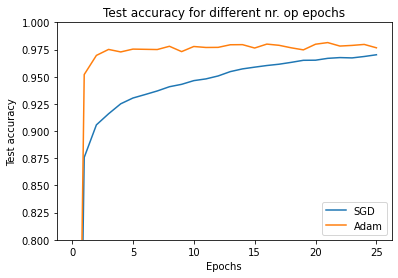

In [16]:
plt.plot(epochs,test_acc_SGD,epochs,test_acc_Adam)
plt.ylim([0.8,1])
plt.legend(['SGD', 'Adam'])
plt.title('Test accuracy for different nr. op epochs')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')

So with SGD we reach a test accuracy of 0.97 after 25 epochs, but still gradually increasing. With Adam we reach a test accuracy of approximately 0.975-0.980 after only 3 epochs. 

## Exercise 2a

In [18]:
test_acc_layers_SGD = np.zeros(10)
test_acc_layers_Adam = np.zeros(10)

num_epochs = 10

for num_layers in range(10):
  hidden = ((50,))*num_layers
  netSGD = MLP(w * h, hidden, k).to(device)
  print(netSGD)
  netAdam = copy.deepcopy(netSGD)
  optimizerSGD = torch.optim.SGD(netSGD.parameters() , lr=0.5)
  optimizerAdam = torch.optim.Adam(netAdam.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08)

  test_acc_SGD = train(netSGD, optimizerSGD, num_epochs)
  test_acc_Adam = train(netAdam, optimizerAdam, num_epochs)

  test_acc_layers_SGD[num_layers] = np.amax(test_acc_SGD)
  test_acc_layers_Adam[num_layers] = np.amax(test_acc_Adam)


MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)
epoch: 0, time: 0.000s, Test accuracy: 0.079
epoch: 1, time: 9.353s, Test accuracy: 0.887
epoch: 2, time: 20.070s, Test accuracy: 0.882
epoch: 3, time: 31.244s, Test accuracy: 0.900
epoch: 4, time: 42.352s, Test accuracy: 0.862
epoch: 5, time: 52.882s, Test accuracy: 0.912
epoch: 6, time: 63.418s, Test accuracy: 0.839
epoch: 7, time: 73.845s, Test accuracy: 0.882
epoch: 8, time: 84.496s, Test accuracy: 0.834
epoch: 9, time: 95.433s, Test accuracy: 0.841
epoch: 10, time: 106.318s, Test accuracy: 0.908
epoch: 0, time: 0.000s, Test accuracy: 0.079
epoch: 1, time: 9.443s, Test accuracy: 0.914
epoch: 2, time: 20.713s, Test accuracy: 0.921
epoch: 3, time: 32.037s, Test accuracy: 0.922
epoch: 4, time: 42.899s, Test accuracy: 0.921
epoch: 5, time: 53.971s, Test accuracy: 0.924
epoch: 6, time: 65.383s, Test accuracy: 0.922
epoch: 7, time: 77.058s, Test accuracy: 0.921
epoch: 8, time: 88.034s, Test ac

Text(0, 0.5, 'Test accuracy (maximum)')

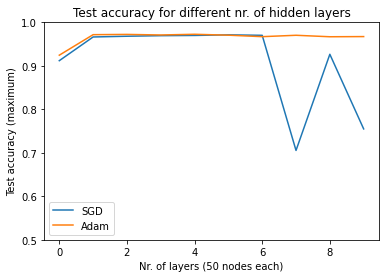

In [20]:
layers = np.arange(0,10)

plt.plot(layers,test_acc_layers_SGD,layers,test_acc_layers_Adam)
plt.ylim([0.5,1])
plt.legend(['SGD', 'Adam'])
plt.title('Test accuracy for different nr. of hidden layers')
plt.xlabel('Nr. of layers (50 nodes each)')
plt.ylabel('Test accuracy (maximum)')